# Comparative Encoder 3D

## 7:25 PM 6.12.22

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
ver = 3

In [4]:
for i in plt.get_fignums():
    plt.close(i)

## Load SILVA Dataset

In [2]:
from Bio import SeqIO
import numpy as np
from tqdm.notebook import tqdm
s = np.array([record for record in tqdm(SeqIO.parse('silva.fasta', "fasta"))], dtype=object)

0it [00:00, ?it/s]

In [3]:
import multiprocessing as mp
from tqdm.notebook import tqdm
def fn(i):
    return np.array(list(str(i.seq)[:300]))
with mp.Pool(50) as p:
    string_seqs = np.array(list(tqdm(p.imap(fn, s, chunksize=100), total=s.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [4]:
BASES = ['A', 'U', 'G', 'C']
def fn(i):
    enc_seq = np.empty((300, 5), dtype=np.intc)
    for bp in range(string_seqs.shape[1]):
        idx = BASES.index(i[bp]) if i[bp] in BASES else 4
        enc_seq[bp] = [1 if j == idx else 0 for j in range(5)]
    return enc_seq
with mp.Pool(50) as p:
    seqs = np.asarray(list(tqdm(p.imap(fn, string_seqs, chunksize=100), total=string_seqs.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [5]:
desc = np.array([i.description.split(' ')[1] for i in s])
num_items = np.vectorize(lambda i: len(i.split(';')))(desc)
parsable = num_items == 7
raw_tax = desc[parsable]
tax = []
for i in raw_tax:
    tax.append(i.split(';'))
tax = np.array(tax)
seqs = seqs[parsable]

## Preprocessing

In [6]:
codes = np.array(['A', 'U', 'G', 'C', 'N'])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(25) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))
str_seqs = decode(seqs.argmax(axis=-1))

  0%|          | 0/180516 [00:00<?, ?it/s]

In [7]:
from sklearn.model_selection import train_test_split
seqs_train, seqs_val, str_seqs_train, str_seqs_val = train_test_split(seqs, str_seqs, test_size=.01)

In [8]:
pairs = np.array(np.meshgrid(np.arange(seqs_val.shape[0]), np.arange(seqs_val.shape[0]))).T.reshape(-1, 2)
val_x1 = seqs_val[pairs[:, 0]]
val_x2 = seqs_val[pairs[:, 1]]

In [9]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(str_seqs_val[pair[0]], str_seqs_val[pair[1]], score_only=True)

import multiprocessing
with multiprocessing.Pool() as p:
    alignments = np.array(list(tqdm(p.imap(align, pairs, chunksize=1000), total=pairs.shape[0])))

val_labels = np.tanh((300 - alignments) / 100)

  0%|          | 0/3261636 [00:00<?, ?it/s]

## Model Definition

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [11]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, a, b):
        return tf.reduce_sum(tf.square(a - b), -1)

In [127]:
import tensorflow as tf
from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    inputs = layers.Input((300, 5))
    den = layers.Dense(50)(inputs)
    res = layers.Reshape((100, 50 * 3))(den)
    
    conv = layers.Conv1D(20, 3)(res)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)
    den = layers.Dense(100 * 50 * 3)(norm)
    res = layers.Reshape((100, 50 * 3))(den)

    trans = TransformerBlock(50 * 3, 4, 100)(res)
    norm = layers.BatchNormalization()(trans)

    trans = TransformerBlock(50 * 3, 4, 100)(norm)
    norm = layers.BatchNormalization()(trans)

    conv = layers.Conv1D(20, 3)(norm)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)

    out = layers.Dense(3)(norm)

    embeddings = tf.keras.Model(inputs=inputs, outputs=out)
embeddings.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 dense_26 (Dense)            (None, 300, 50)           300       
                                                                 
 reshape_6 (Reshape)         (None, 100, 150)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 20)            9020      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 49, 20)           0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 980)               0         
                                                           

In [132]:
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def combined_loss(y_true, y_pred):
    return correlation_coefficient_loss(y_true, y_pred) #+ tf.keras.losses.MeanSquaredError(
#         tf.keras.losses.Reduction.NONE)(y_true, y_pred)

with mirrored_strategy.scope():
    inputa = layers.Input((300, 5), name='input_a')
    inputb = layers.Input((300, 5), name='input_b')
    distances = DistanceLayer()(
        embeddings(inputa),
        embeddings(inputb),
    )
    siamese_network = tf.keras.Model(inputs=[inputa, inputb], outputs=distances)
    siamese_network.compile(optimizer='adam',
                    loss=combined_loss,
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
siamese_network.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 input_b (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 model_9 (Functional)           (None, 3)            15530923    ['input_a[0][0]',                
                                                                  'input_b[0][0]']                
                                                                                                  
 distance_layer_6 (DistanceLaye  (None,)             0           ['model_9[2][0]',         

### Load 2D Model

In [14]:
custom_objects = {'combined_loss': combined_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    siamese_network_it2 = tf.keras.models.load_model('Models/comparative_encoder2/full_model')
    embeddings_it2 = tf.keras.models.load_model('Models/comparative_encoder2/encoder')

In [42]:
it2_layers = embeddings_it2.layers
for i in range(len(it2_layers) - 1):
    embeddings.layers[i].set_weights(it2_layers[i].get_weights())

In [131]:
weights = siamese_network.get_weights()

In [133]:
siamese_network.set_weights(weights)

## Training

In [129]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)

codes = np.array(['A', 'U', 'G', 'C', 'N'])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(25) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))

from sklearn.model_selection import train_test_split
rng = np.random.default_rng()
def randomized_epoch(data, str_data):
    p1 = rng.permutation(data.shape[0])
    p2 = rng.permutation(data.shape[0])
    x1, x1_str = data[p1], str_data[p1]
    x2, x2_str = data[p2], str_data[p2]
    
    import multiprocessing
    with multiprocessing.Pool(50) as p:
        aln = np.array(list(tqdm(p.imap(align, zip(x1_str, x2_str), chunksize=1000), total=x1_str.shape[0])))
    y = np.tanh((300 - aln) / 100)
    
    train_data = tf.data.Dataset.from_tensor_slices(({'input_a': x1, 'input_b': x2}, y))
    train_data = train_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_data = train_data.with_options(options)
    
    siamese_network.fit(train_data, epochs=1)

def validate():
    val_data = tf.data.Dataset.from_tensor_slices((
        {'input_a': val_x1[:100000], 'input_b': val_x2[:100000]},))
    val_data = val_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    val_data = val_data.with_options(options)
    pred = siamese_network.predict(val_data)
    return np.corrcoef(pred, val_labels[:100000])[0, 1] ** 2, ((pred - val_labels[:100000]) ** 2).mean()

def train(epochs):
    for i in range(epochs):
        print(f'Epoch {i + 1}:')
        randomized_epoch(seqs_train, str_seqs_train)
        val_r, val_mse = validate()
        print(f'val_mse: {val_mse}; val_r2: {val_r}')

In [86]:
K.set_value(siamese_network.optimizer.learning_rate, .001)

In [134]:
train(300)

Epoch 1:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 6s 34ms/step
val_mse: 721831.3259262576; val_r2: 0.5319110235550354
Epoch 2:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 648662.3479790272; val_r2: 0.5504267075360366
Epoch 3:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 625769.0813168405; val_r2: 0.54892418725136
Epoch 4:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 782933.1381968023; val_r2: 0.551291937842175
Epoch 5:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 784817.7602921837; val_r2: 0.5512733295877763
Epoch 6:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 743745.1947712197; val_r2: 0.5547495427314937
Epoch 7:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 787271.2288037642; val_r2: 0.5547216208837928
Epoch 8:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 34ms/step
val_mse: 869216.9261700619; val_r2: 0.5562689229722959
Epoch 9:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 781665.2914887853; val_r2: 0.5533018449933309
Epoch 10:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 808940.2055050489; val_r2: 0.5544571577078949
Epoch 11:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 34ms/step
val_mse: 805019.7417624049; val_r2: 0.5507473606977485
Epoch 12:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 887035.3798421276; val_r2: 0.5554081894879652
Epoch 13:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 893339.43675482; val_r2: 0.5503424562190649
Epoch 14:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 923223.8169380632; val_r2: 0.5535518958111102
Epoch 15:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 34ms/step
val_mse: 910315.3226282881; val_r2: 0.5556123239865712
Epoch 16:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 968810.345819551; val_r2: 0.552678294337905
Epoch 17:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 880321.2085194003; val_r2: 0.5483721773242165
Epoch 18:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 945927.2030994834; val_r2: 0.5536471903552649
Epoch 19:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 992043.2703818136; val_r2: 0.5507460861064303
Epoch 20:


  0%|          | 0/178710 [00:00<?, ?it/s]

100/100 [==============================] - 4s 33ms/step
val_mse: 1172043.1036839075; val_r2: 0.5554508120782451
Epoch 21:


  0%|          | 0/178710 [00:00<?, ?it/s]

 39/100 [==========>...................] - ETA: 2s

KeyboardInterrupt: 

In [245]:
siamese_network.save(f'Models/comparative_encoder{ver}/full_model')
embeddings.save(f'Models/comparative_encoder{ver}/encoder')

In [49]:
embeddings.trainable = False
siamese_network.trainable = False

## Evaluation on SILVA

In [135]:
seq_reps = embeddings.predict(seqs, batch_size=1000)

2022-06-13 16:22:31.918937: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_773151"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:13999"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

181/181 [==============================] - 5s 20ms/step


### Correlation Plot

  0%|          | 0/10000 [00:00<?, ?it/s]

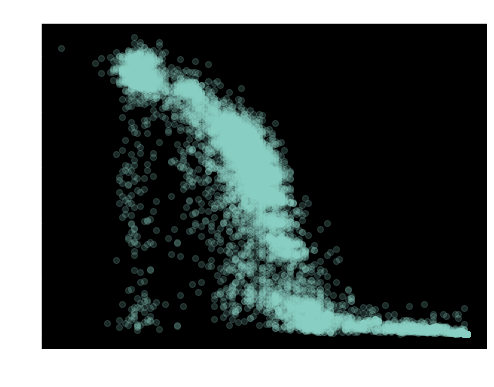

In [136]:
import random
from scipy.spatial.distance import euclidean
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
def evaluate():
    a = random.randint(0, seq_reps.shape[0] - 1)
    b = random.randint(0, seq_reps.shape[0] - 1)
    pred = euclidean(seq_reps[a], seq_reps[b])
    first = to_str(seqs[a].argmax(-1))
    second = to_str(seqs[b].argmax(-1))
    aln = align((first, second))
#     score = np.tanh((300 - aln) / 100)
    score = aln
    return [score, pred]
results = np.asarray([evaluate() for i in tqdm(range(10000))])
f = plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], alpha=.2)
plt.xlabel('Pairwise Similarity Score (Smith-Waterman)')
plt.ylabel('Euclidean Distance Between Encodings')
plt.title('Correlation Plot of Model Encodings')
plt.savefig(f'Results/it{ver}/silva/eval/comparative_enc_eval.png')

In [137]:
results[:, 0].mean()

230.0844

In [138]:
np.corrcoef(results[:, 0], results[:, 1])

array([[ 1.        , -0.83042886],
       [-0.83042886,  1.        ]])

In [139]:
np.mean((results[:, 0] - results[:, 1]) ** 2)

42833.879047955365

### SILVA Clustering

In [140]:
%matplotlib inline

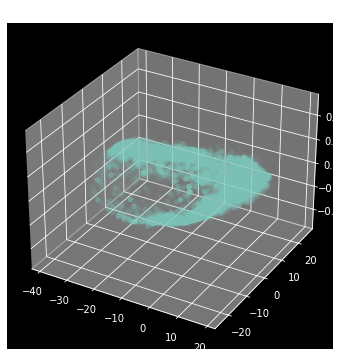

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
x, y, z = np.array(seq_reps).T
f = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, alpha=.05, marker='o')
plt.title("Encoded Representations of SILVA Database")
plt.savefig(f'Results/it{ver}/silva/silva_all.png')
# plt.show()

#### Domain

In [205]:
archaea = seq_reps[tax[:, 0] == 'Archaea']
bacteria = seq_reps[tax[:, 0] == 'Bacteria']
eukaryota = seq_reps[tax[:, 0] == 'Eukaryota']

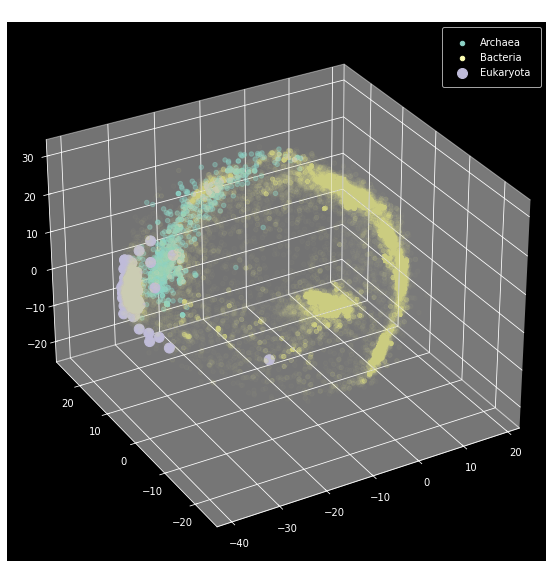

In [224]:
plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.axes(projection='3d')
ax.scatter(archaea[:, 0], archaea[:, 1], archaea[:, 2], alpha=.4)
ax.scatter(bacteria[:, 0], bacteria[:, 1], bacteria[:, 2], alpha=.02)
ax.scatter(eukaryota[:, 0], eukaryota[:, 1], eukaryota[:, 2], alpha=1, marker='o', s=100)
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
ax.view_init(30, -120)
plt.title('Encoded Representations of the Domains of Life')
plt.savefig(f'Results/it{ver}/silva/silva_domains.png')
plt.show()

#### Phylum (Bacteria)

In [197]:
a, b = np.unique(tax[tax[:, 0] == 'Bacteria'][:, 1], return_counts=True)
genuses = a[b > 1000]

In [198]:
plottable = np.isin(tax[:, 1], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 1] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

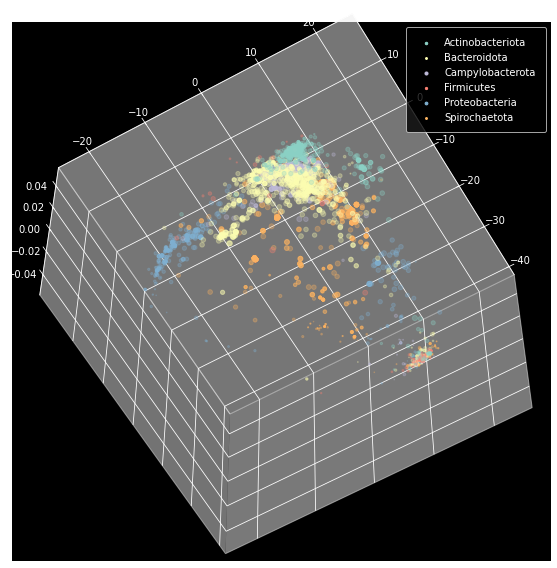

In [204]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.axes(projection='3d')
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    plt.scatter(x, y, z, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

ax.view_init(-60, 30)
plt.savefig(f'Results/it{ver}/silva/silva_phylum.png')
plt.show()

#### Class (Proteobacteria)

In [193]:
a, b = np.unique(tax[tax[:, 1] == 'Proteobacteria'][:, 2], return_counts=True)
genuses = a[b > 500]

In [194]:
plottable = np.isin(tax[:, 2], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 2] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

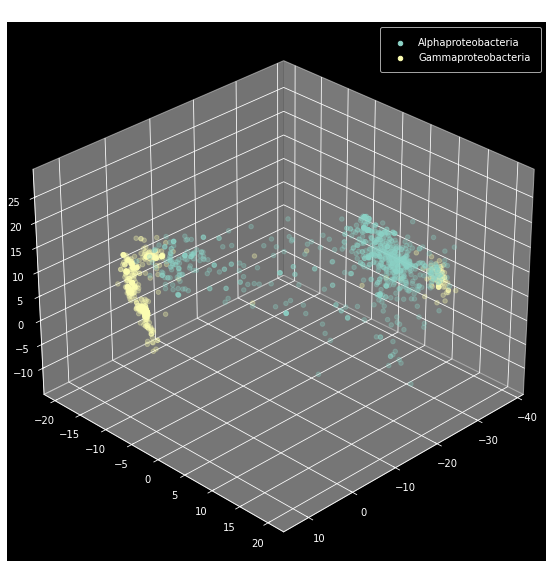

In [196]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.axes(projection='3d')
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Classes of Proteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

ax.view_init(30, 45)
plt.savefig(f'Results/it{ver}/silva/silva_class.png')
plt.show()

#### Order (Alphaproteobacteria)

In [180]:
a, b = np.unique(tax[tax[:, 2] == 'Alphaproteobacteria'][:, 3], return_counts=True)
genuses = a[b > 500]

In [181]:
plottable = np.isin(tax[:, 3], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 3] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

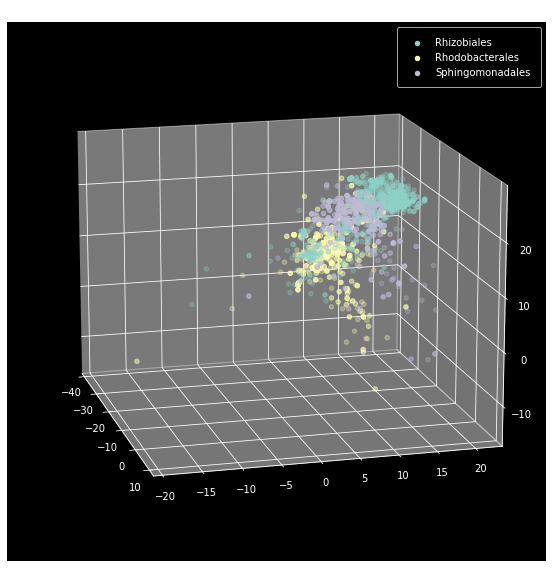

In [191]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 8]
ax = plt.axes(projection='3d')
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Orders of Alphaproteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

ax.view_init(15, -15)
plt.savefig(f'Results/it{ver}/silva/silva_order.png')
plt.show()

#### Genus (Rhizobiales Rhizobiaceae)

In [227]:
a, b = np.unique(tax[tax[:, 4] == 'Rhizobiaceae'][:, 5], return_counts=True)
genuses = a[b > 500]

In [228]:
plottable = np.isin(tax[:, 5], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 5] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

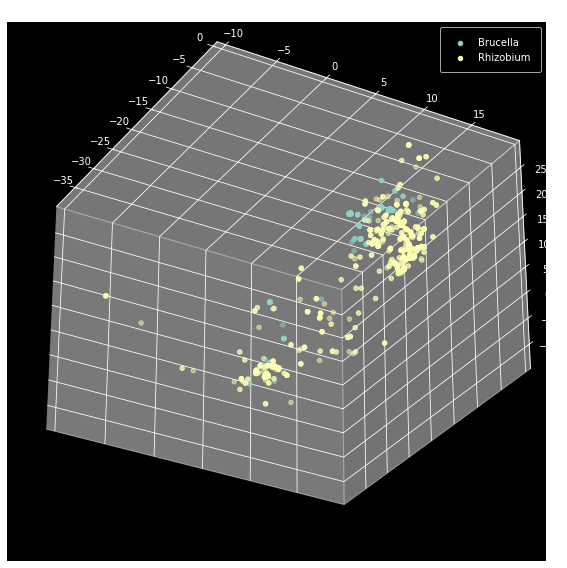

In [229]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.5, marker='o')
ax.set_title("Encoded Representations of Genuses of Rhizobiaceae")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
ax.view_init(-30, -30)
plt.savefig(f'Results/it{ver}/silva/silva_genus.png')
plt.show()

# ANC Data

## Preprocessing

### Load

In [230]:
label_map = {
    "S002": "black",
    "S001": "grey",
    "S003": "unpigmented"
}
def read_ion_reporter(path):
    import os
    import pandas as pd
    import numpy as np
    from Bio import SeqIO
    from tqdm.notebook import tqdm
    import re

    paths = np.array([])  # Get paths to all fasta files
    for root, dirs, files in os.walk(path):
        paths = np.append(paths, [os.path.join(root, i) for i in files if i.endswith(".fasta")])

    def read(i):  # Function to parse a fasta file and get all records
        s = np.array([record for index, record in enumerate(SeqIO.parse(i, "fasta"))] + [0], dtype=object)
        s = s[:-1]  # We append 0 and remove it so that single element arrays get parsed as such
        l = np.full_like(s, label_map[i.split("/")[-1][:4]])
        return s, l

    seqs, labels, desc = np.array([]), np.array([]), np.array([])
    for i in paths:  # Parse all sequences, generate labels
        s, l = read(i)
        seqs = np.append(seqs, s)
        labels = np.append(labels, l)
    # flattened_seqs = np.concatenate(seqs)  # Flatten because we don't care about which sample the data came from
    string_seqs = np.vectorize(lambda i: str(i.seq))(seqs)  # Convert to strings
    descriptions = np.vectorize(lambda i: i.description)(seqs)

    return string_seqs, labels, descriptions

arlington, arlington_labels, arlington_desc = read_ion_reporter("Data/Arlington Processed")

### Header Parsing

In [231]:
import re
def get_size(s: str):
    parts = s.split('|')
    idx = -1
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            idx = i
            break
    if idx == -1:
        return 0
    return len(parts[i + 1:])

import numpy as np
arlington_known = np.vectorize(get_size)(arlington_desc) != 0
arlington = arlington[arlington_known]
arlington_labels = arlington_labels[arlington_known]
arlington_desc = arlington_desc[arlington_known]

def get_tax(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    tax = [x.strip('[]') for x in parts[i + 1:-1]]
    unc = ["UNKNOWN"] * 6
    cond = ['/' not in i and 'sp.' not in i for i in tax]
    return np.where(cond, tax, unc)

arlington_tax = np.empty((arlington_desc.shape[0], 6), dtype=object)
for i in range(arlington_desc.shape[0]):
    arlington_tax[i, :] = get_tax(arlington_desc[i])

def get_conf(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return float(parts[i])

arlington_conf = np.vectorize(get_conf)(arlington_desc)

def get_abund(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return int(parts[i - 1])

arlington_abund = np.vectorize(get_abund)(arlington_desc)

### Sequence Encoding

In [232]:
def preprocess_reads(x):
    from tqdm.notebook import tqdm
    from sklearn import preprocessing
    import numpy as np

    BASES = ["A", "T", "G", "C"]

    LENGTH = 300

    # mask = np.vectorize(len)(x) >= LENGTH
    seqs = np.vectorize(lambda i: i[:LENGTH])(x)

    print("Encoding sequences...")
    # Sequence encoding
    def encode_seq(seq: str):  # Function to encode a sequence using one-hot encoding
        idx = [BASES.index(char) for char in seq]
        return [[(1 if j == i else 0) for j in range(5)] for i in idx]
    # Time consuming step, vectorize if possible!!!
    final_seqs = np.empty((seqs.shape[0], LENGTH, 5), dtype=np.int32)  # Init empty array
    for i in tqdm(range(len(seqs))):  # Iterate over sequences
        encoded = encode_seq(seqs[i][:LENGTH])  # Encode each sequence
        final_seqs[i] = np.concatenate([np.zeros((LENGTH - len(encoded), 5)), encoded])

    return final_seqs

arlington_processed = preprocess_reads(arlington)

Encoding sequences...


  0%|          | 0/17142 [00:00<?, ?it/s]

### Variable Region Separation

#### Preprocessing

In [233]:
def get_variable_region(i):  # Function to get the variable region from the record's description
    header_parts = i.split("|")  # Header is | delimited
    variable_region = "UNKNOWN"  # Default variable region
    for val in header_parts:  # Iterate over the header parts
        if result := re.search(r"^V\d+", val):  # Match any pattern starting with a V and ending with digits
            variable_region = val  # Set variable region to the text in the matched part of the header
            break
    return variable_region

import numpy as np
v_regions = np.vectorize(get_variable_region)(arlington_desc)

known_mask = v_regions != 'UNKNOWN'
known_seqs, known_labels = arlington_processed[known_mask], v_regions[known_mask]

from sklearn.preprocessing import LabelBinarizer
bn = LabelBinarizer()
v_regions_enc = bn.fit_transform(known_labels)

#### NN Classifier

In [234]:
import tensorflow as tf
inputs = tf.keras.layers.Input((300, 5))
hidden = tf.keras.layers.Dense(300, activation='relu')(inputs)
flat = tf.keras.layers.Flatten()(hidden)
outputs = tf.keras.layers.Dense(v_regions_enc.shape[1], activation='softmax')(flat)

v_region_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
v_region_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
v_region_classifier.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 dense_33 (Dense)            (None, 300, 300)          1800      
                                                                 
 flatten_8 (Flatten)         (None, 90000)             0         
                                                                 
 dense_34 (Dense)            (None, 6)                 540006    
                                                                 
Total params: 541,806
Trainable params: 541,806
Non-trainable params: 0
_________________________________________________________________


In [235]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(known_seqs, v_regions_enc, test_size=.2)
import tensorflow as tf
v_region_classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
                       batch_size=100,
                       epochs=100)

Epoch 1/100
69/69 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.9672 - val_loss: 0.0117 - val_accuracy: 0.9977
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.0066 - val_accuracy: 0.9977
Epoch 3/100
69/69 [==============================] - 0s 3ms/step - loss: 9.3384e-04 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9977
Epoch 4/100
69/69 [==============================] - 0s 3ms/step - loss: 4.9952e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9977
Epoch 5/100
69/69 [==============================] - 0s 3ms/step - loss: 3.2920e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9977
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 2.3879e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9977
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 1.8046e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 

#### Classify All Seqs

In [236]:
unknown_labels = v_region_classifier.predict(arlington_processed[~known_mask], verbose=1)
int_predictions = unknown_labels.argmax(axis=1)
predictions = np.vectorize(lambda i: bn.classes_[i])(int_predictions)
certainty = unknown_labels.max(axis=1)
print(certainty.shape, np.nonzero(certainty > .99)[0].shape)  # We can classify almost everything with 99% confidence

v_region_labels = np.full_like(v_regions, 'UNKNOWN')
v_region_labels[known_mask] = known_labels
a = v_region_labels[~known_mask]
a[certainty > .99] = predictions[certainty > .99]
v_region_labels[~known_mask] = a
print(v_region_labels[v_region_labels != 'UNKNOWN'].shape[0] / v_region_labels.shape[0])
# We successfully classified about 99% of our unknown data

268/268 [==============================] - 0s 1ms/step
(8571,) (8557,)
0.9991832924979582


### Prep for Model

In [237]:
codes = np.array(['A', 'U', 'G', 'C', 'N'])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(2) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))
anc_str_seqs = decode(arlington_processed.argmax(axis=-1))

  0%|          | 0/17142 [00:00<?, ?it/s]

In [238]:
from sklearn.model_selection import train_test_split
anc_seqs_train, anc_seqs_val, anc_str_seqs_train, anc_str_seqs_val = \
    train_test_split(arlington_processed, anc_str_seqs, test_size=.01)

In [239]:
pairs = np.array(np.meshgrid(np.arange(anc_seqs_val.shape[0]), np.arange(anc_seqs_val.shape[0]))).T.reshape(-1, 2)
anc_val_x1 = anc_seqs_val[pairs[:, 0]]
anc_val_x2 = anc_seqs_val[pairs[:, 1]]

In [240]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(str_seqs_val[pair[0]], str_seqs_val[pair[1]], score_only=True)

import multiprocessing
with multiprocessing.Pool(10) as p:
    anc_alignments = np.array(list(tqdm(p.imap(align, pairs, chunksize=1000), total=pairs.shape[0])))

anc_val_labels = np.tanh((300 - anc_alignments) / 100)

  0%|          | 0/29584 [00:00<?, ?it/s]

## Fine-Tuning

### Model Definition

In [241]:
import tensorflow as tf
from tensorflow.keras import layers
with mirrored_strategy.scope():
    anc_input = layers.Input((300, 5))
    res = layers.Reshape((5, 300))(anc_input)
    mid = layers.Dense(300)(res)
    
    conv = layers.Conv1D(20, 3)(mid)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)
    den = layers.Dense(300 * 5)(norm)
    
    res = layers.Reshape((300, 5))(den)
    embed = embeddings(res)

    fine_embeddings = tf.keras.Model(inputs=anc_input, outputs=embed)

fine_embeddings.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 reshape_8 (Reshape)         (None, 5, 300)            0         
                                                                 
 dense_35 (Dense)            (None, 5, 300)            90300     
                                                                 
 conv1d_8 (Conv1D)           (None, 3, 20)             18020     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 20)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 20)                0         
                                                          

In [242]:
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def combined_loss(y_true, y_pred):
    return correlation_coefficient_loss(y_true, y_pred) #+ tf.keras.losses.MeanSquaredError(
#         tf.keras.losses.Reduction.NONE)(y_true, y_pred)

with mirrored_strategy.scope():
    inputa = layers.Input((300, 5), name='input_a')
    inputb = layers.Input((300, 5), name='input_b')
    distances = DistanceLayer()(
        fine_embeddings(inputa),
        fine_embeddings(inputb),
    )
    fine_siamese = tf.keras.Model(inputs=[inputa, inputb], outputs=distances)
    fine_siamese.compile(optimizer='adam',
                    loss=combined_loss,
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
fine_siamese.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 input_b (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 model_13 (Functional)          (None, 3)            15670823    ['input_a[0][0]',                
                                                                  'input_b[0][0]']                
                                                                                                  
 distance_layer_7 (DistanceLaye  (None,)             0           ['model_13[0][0]',        

### Training

In [243]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)

rng = np.random.default_rng()
def single_batch(arr1, arr2):
    p = rng.permutation(arr1.shape[0])
    return arr1[p], arr2[p]

def large_batch(arr1, arr2, size):
    x1, x2 = [], []
    for i in range(size):
        a, b = single_batch(arr1, arr2)
        x1.append(a)
        x2.append(b)
    return np.concatenate(x1), np.concatenate(x2)

from sklearn.model_selection import train_test_split
def randomized_epoch(data, str_data):
    x1, x1_str = large_batch(data, str_data, 10)
    x2, x2_str = large_batch(data, str_data, 10)
    
    with mp.Pool(30) as p:
        aln = np.array(list(tqdm(p.imap(align, zip(x1_str, x2_str), chunksize=100), total=x1_str.shape[0])))
    y = np.tanh((300 - aln) / 100)
    
    train_data = tf.data.Dataset.from_tensor_slices(({'input_a': x1, 'input_b': x2}, y))
    train_data = train_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_data = train_data.with_options(options)
    
    fine_siamese.fit(train_data, epochs=1)

def validate():
    val_data = tf.data.Dataset.from_tensor_slices((
        {'input_a': anc_val_x1[:10000], 'input_b': anc_val_x2[:10000]},))
    val_data = val_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    val_data = val_data.with_options(options)
    pred = fine_siamese.predict(val_data)
    return np.corrcoef(pred, anc_val_labels[:10000])[0, 1] ** 2, ((pred - anc_val_labels[:10000]) ** 2).mean()

def train(epochs):
    for i in range(epochs):
        print(f'Epoch {i + 1}:')
        randomized_epoch(anc_seqs_train, anc_str_seqs_train)
#         val_r, val_mse = validate()
#         print(f'val_mse: {val_mse}; val_r2: {val_r}')

In [492]:
K.set_value(fine_siamese.optimizer.learning_rate, .0001)

In [246]:
train(100)

Epoch 1:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 31s 109ms/step - loss: 0.4822 - mean_absolute_error: 857.8585
Epoch 2:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 109ms/step - loss: 0.4206 - mean_absolute_error: 974.3007
Epoch 3:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 110ms/step - loss: 0.4169 - mean_absolute_error: 1085.2203
Epoch 4:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 110ms/step - loss: 0.4189 - mean_absolute_error: 1177.1442
Epoch 5:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 110ms/step - loss: 0.4137 - mean_absolute_error: 1288.1548
Epoch 6:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 110ms/step - loss: 0.4136 - mean_absolute_error: 1373.6846
Epoch 7:


  0%|          | 0/169700 [00:00<?, ?it/s]

170/170 [==============================] - 19s 110ms/step - loss: 0.4158 - mean_absolute_error: 1483.8889
Epoch 8:


  0%|          | 0/169700 [00:00<?, ?it/s]

125/170 [=====================>........] - ETA: 4s - loss: 0.4117 - mean_absolute_error: 1596.3020

KeyboardInterrupt: 

In [247]:
fine_siamese.save(f'Models/comparative_encoder{ver}/full_model_anc')
fine_embeddings.save(f'Models/comparative_encoder{ver}/encoder_anc')

### Evaluation

In [248]:
anc_seq_reps = fine_embeddings.predict(arlington_processed, batch_size=1000)

2022-06-13 17:14:07.784014: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_855482"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:14350"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

18/18 [==============================] - 2s 25ms/step


#### Correlation Plot

  0%|          | 0/10000 [00:00<?, ?it/s]

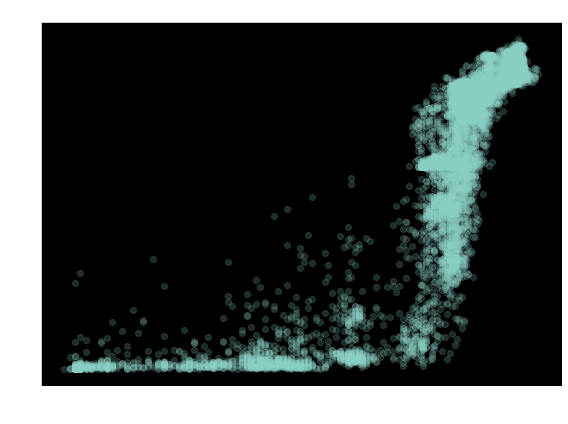

In [249]:
import random
from scipy.spatial.distance import euclidean
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
def evaluate():
    a = random.randint(0, anc_seq_reps.shape[0] - 1)
    b = random.randint(0, anc_seq_reps.shape[0] - 1)
    pred = euclidean(anc_seq_reps[a], anc_seq_reps[b])
    first = to_str(arlington_processed[a].argmax(-1))
    second = to_str(arlington_processed[b].argmax(-1))
    aln = align((first, second))
    score = np.tanh((300 - aln) / 100)
    return [score, pred]
results = np.asarray([evaluate() for i in tqdm(range(10000))])
f = plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], alpha=.2)
plt.xlabel('Pairwise Similarity Score (Smith-Waterman)')
plt.ylabel('Euclidean Distance Between Encodings')
plt.title('Correlation Plot of Model Encodings')
plt.savefig(f'Results/it{ver}/anc/eval/comparative_enc_eval_anc.png')

In [250]:
np.corrcoef(results[:, 0], results[:, 1])

array([[1.        , 0.84290859],
       [0.84290859, 1.        ]])

In [251]:
np.mean((results[:, 0] - results[:, 1]) ** 2)

1755.088424914796

#### Full Dataset Visualization

/opt/apps/intel19/python3/3.9.7/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


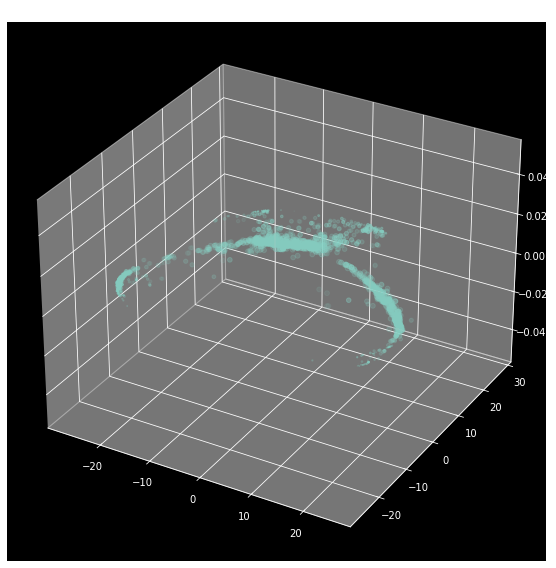

In [253]:
x, y, z = anc_seq_reps.T
ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
plt.scatter(x, y, z, alpha=.1, marker='o')
plt.title("Encoded Representations of ANC Dataset")
plt.savefig(f'Results/it{ver}/anc/anc_all.png')

## Dataset Exploration

### Phylum

In [254]:
all_phyla, counts = np.unique(arlington_tax[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [255]:
plottable = np.isin(arlington_tax[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_seq_reps[plottable]

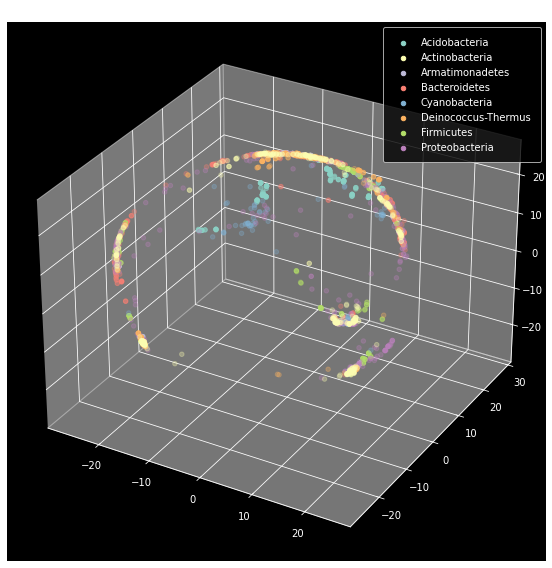

In [256]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_phylum.png')

### Variable Region

In [266]:
all_regions, counts = np.unique(v_region_labels, return_counts=True)
genuses = all_regions[counts > 50]

In [267]:
plottable = np.isin(v_region_labels, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[v_region_labels[plottable] == genuses[i], i] = 1
plottable_seqs = anc_seq_reps[plottable]

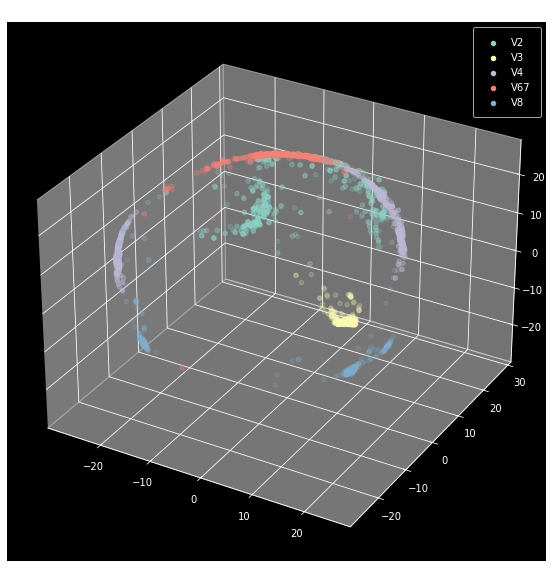

In [268]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.2, marker='o')
ax.set_title("Encoded Representations (Colored by Variable Region)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_vregion.png')

### V8

In [281]:
subset = v_region_labels == 'V2'
arlington_tax_sub = arlington_tax[subset]
anc_2d_sub = anc_seq_reps[subset]
anc_lbl_sub = arlington_labels[subset]

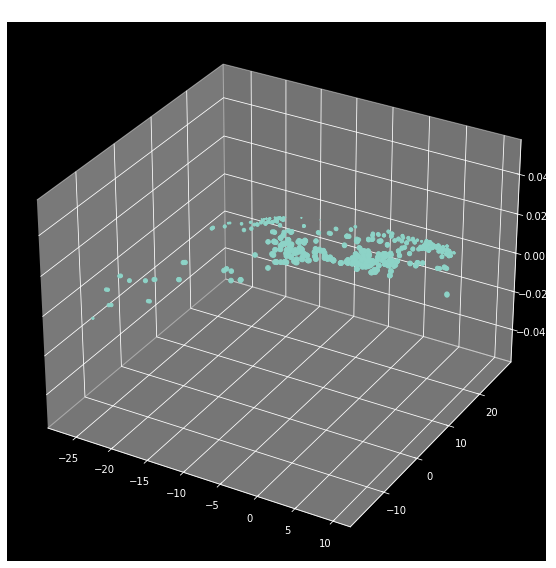

In [282]:
ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
plt.scatter(anc_2d_sub[:, 0], anc_2d_sub[:, 1], anc_2d_sub[:, 2], alpha=1)
plt.title('V8 Sequences from Arlington National Cemetery')
plt.savefig(f'Results/it{ver}/anc/anc_v8.png')

#### Phylum

In [283]:
all_phyla, counts = np.unique(arlington_tax_sub[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [284]:
plottable = np.isin(arlington_tax_sub[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

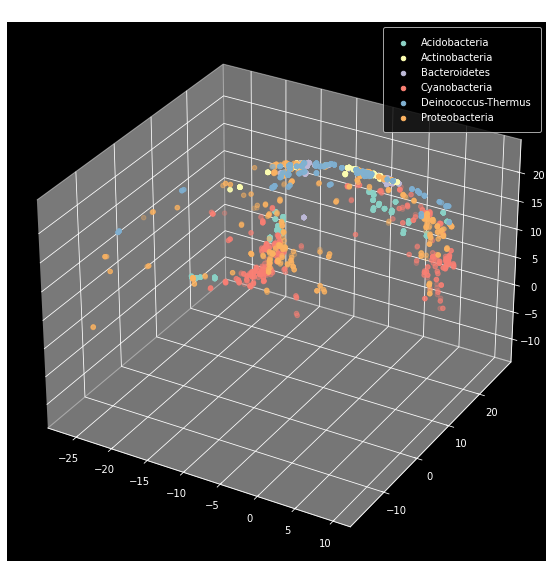

In [285]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y, z = zip(*pop[samp])
    ax.scatter(x, y, z, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_phylum.png')

#### Pigment

In [286]:
all_phyla, counts = np.unique(anc_lbl_sub, return_counts=True)
genuses = all_phyla[counts > 50]

In [287]:
plottable = np.isin(anc_lbl_sub, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[anc_lbl_sub[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

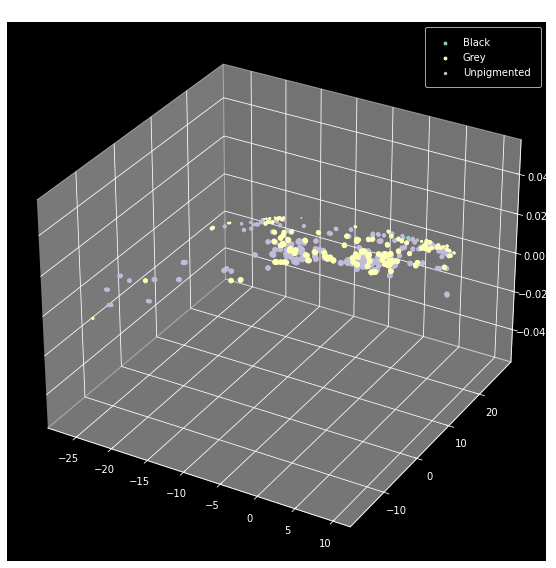

In [288]:
ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = [8, 8]
black, grey, unpigmented = anc_lbl_sub == 'black', anc_lbl_sub == 'grey', anc_lbl_sub == 'unpigmented'
plt.scatter(anc_2d_sub[black][:, 0], anc_2d_sub[black][:, 1], anc_2d_sub[black][:, 2], alpha=1)
plt.scatter(anc_2d_sub[grey][:, 0], anc_2d_sub[grey][:, 1], anc_2d_sub[grey][:, 2], alpha=1)
plt.scatter(anc_2d_sub[unpigmented][:, 0], anc_2d_sub[unpigmented][:, 1], anc_2d_sub[unpigmented][:, 2], alpha=1)
ax.set_title("Encoded Representations of V8 Bacteria, by Pigmentation")
leg = plt.legend(['Black', 'Grey', 'Unpigmented'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_pigment.png')